To break down the question of what is happening in the Birmingham property market I have decided to focus on two questions which will help us understand the effect of HS2 on different areas.

### 1) Has HS2 caused any changes in number of property sales?
### 2) How has HS2 affected property prices in different areas around Birmingham?

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_price = pd.read_csv('data/Land Registry Price Paid Data.csv')
df_type = pd.read_csv('data/VOA Property Type Data.csv')
df_age = pd.read_csv('data/VOA Property Age Data.csv')
print(df_price.head(1).transpose())

                                                   0
LRUniqueID    {E0E65E87-B106-4411-961F-05AD44B2466F}
SalePrice                                     110000
SaleDate                                  2010-10-01
PCUnit                                      B19 2AT 
PropertyType                                       T
NewBuild                                           N
Freehold                                           F
Add1                                              26
Add2                                             NaN
Add3                                  LOZELLS STREET
Add4                                             NaN
Add5                                      BIRMINGHAM
Add6                                      BIRMINGHAM
Add7                                   WEST MIDLANDS
oslaua                                     E08000025
lsoa11                                     E01033628
oa11                                       E00045244
Easting                                       

In [2]:
#This dataset contains properties from a huge area around Birmingham so we need to be careful using all of it
print(df_price['Add5'].unique())
print(df_price['Add6'].unique())

['BIRMINGHAM' 'SUTTON COLDFIELD' 'HALESOWEN' 'SOLIHULL']
['BIRMINGHAM' 'SANDWELL' 'SOLIHULL' 'COVENTRY' 'BROMSGROVE' 'REDDITCH'
 'SUTTON' 'LICHFIELD' 'DUDLEY' 'WALSALL' 'SOUTH GLOUCESTERSHIRE' 'WARWICK'
 'WOLVERHAMPTON']


# Feature Engineering

In [3]:
#Convert current date column into datetime object for easy time based manipulation
from datetime import datetime
df_price['SaleDate'] = df_price.apply(lambda x: datetime.strptime(x['SaleDate'], '%Y-%m-%d'), axis=1)
df_price['SaleYear'] = df_price.apply(lambda x: x['SaleDate'].year, axis=1)
df_price['SaleMonth'] = df_price.apply(lambda x: x['SaleDate'].month, axis=1)
df_price['SaleDay'] = df_price.apply(lambda x: x['SaleDate'].day, axis=1)
df_price['SaleYearMonth'] = df_price['SaleYear'] + df_price['SaleMonth']/12

One of the first things I looked to analyse was whether the distance from the station had any bearing on the house price changes. The function below can calcuate the distance between a property and the HS2 station, we use this to add a new column to the data with this distance.

In [4]:
import geopy.distance

#Coordinates from https://latitude.to/articles-by-country/gb/united-kingdom/28779/curzon-street-railway-station
hs2_station_coords = (52.4756314308,  -1.88515312604) 

first_property_coords = (df_price['Latitude'][0], df_price['Longitude'][0])

hs2_property_distance = geopy.distance.geodesic(hs2_station_coords, first_property_coords).km

print('The distance between the first property in the dataset and HS2 is ' 
      + str(round(hs2_property_distance,1))
      +'km.')

The distance between the first property in the dataset and HS2 is 3.2km.


In [5]:
df_price['Distance_from_HS2_km'] = df_price.apply(lambda x: geopy.distance.geodesic(
                                                    hs2_station_coords, (x['Latitude'],x['Longitude'])).km, axis=1)

One theory about how HS2 will increase house prices in Birmingham is that more people will be able live in Birmingham and commute into London. People who will be doing this will want to live close to the station so lets make flag for whether people are within reasonable walking distance to the HS2 station.
<br> <br> 
The mean distance walked to a train station by people in the UK is ~1k [1]. Lets add a flag for a whether a property is within a reasonable walking distance of the station.
<br> <br> 
[1]: https://www.wyg.com/uploads/files/news/WYG_how-far-do-people-walk.pdf

In [6]:
df_price['Less_than_1k_away'] = df_price.apply(lambda x: 1 if x['Distance_from_HS2_km'] < 1 else 0, axis=1)

HS2 was proposed in 10th January 2012 [1] and approved by parliment in 23rd Feburary 2017 [2]. Lets add flags for whether the property was sold after these dates.<br> <br>[1]:https://www.gov.uk/government/news/britain-to-have-new-national-high-speed-rail-network <br>[2]:https://www.gov.uk/government/collections/high-speed-rail-london-west-midlands-bill

In [7]:
df_price['Sale_after_hs2_proposal'] = df_price.apply(lambda x: 1 if x['SaleDate'] >= 
                                                datetime.strptime('2012-01-10', '%Y-%m-%d') else 0, axis=1)

df_price['Sale_after_hs2_approval'] = df_price.apply(lambda x: 1 if x['SaleDate'] >= 
                                                datetime.strptime('2017-02-23', '%Y-%m-%d') else 0, axis=1)

### 1) Has HS2 caused any changes in number of property sales?

In [8]:
print(min(df_price['SaleDate'])) #Data starts on Jan 2nd which is fine
print(max(df_price['SaleDate'])) #But it ends on 26th Nov so we need to scale up 2019

2009-01-02 00:00:00
2019-11-26 00:00:00


In [9]:
#Group by year and count how many are in each group
df_sale_count = df_price[['SaleYear','LRUniqueID']].groupby(['SaleYear']).count()
df_sale_count = df_sale_count['LRUniqueID']

In [10]:
#Lets assume sales are consistent throughout the year, as 329 days have passed already we need to scale up by 365/329
df_sale_count[2019] = df_sale_count[2019] * (365/329) 

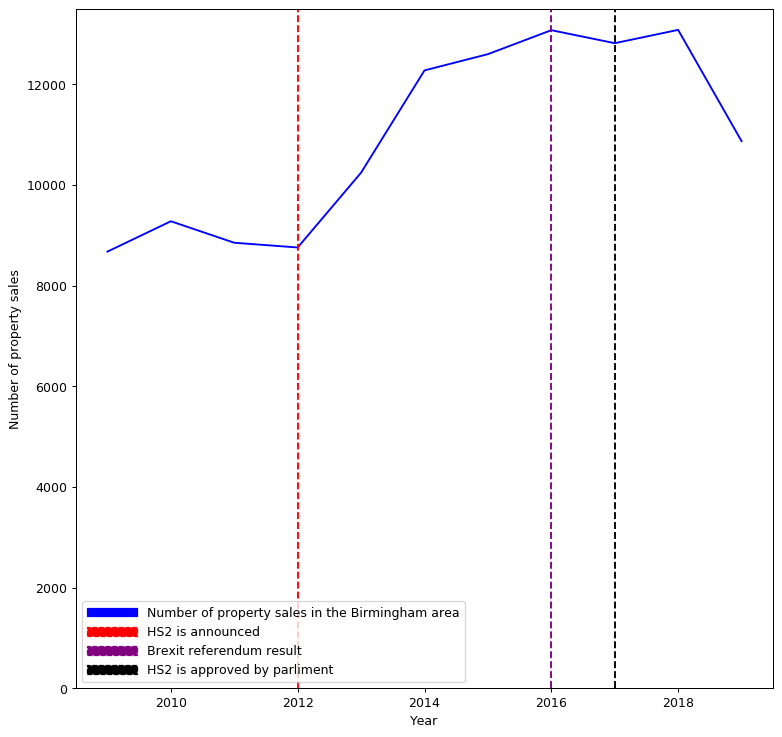

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 10), dpi=90, facecolor='w', edgecolor='k')

blue_patch = mpatches.Patch(color='blue', label='Number of property sales in the Birmingham area')
black_patch = mpatches.Patch(color='black', label='HS2 is approved by parliment', linestyle='--')
red_patch = mpatches.Patch(color='red', label='HS2 is announced', linestyle='--')
purple_patch = mpatches.Patch(color='purple', label='Brexit referendum result', linestyle='--')

leg = plt.legend(handles=[blue_patch, red_patch, purple_patch, black_patch],handlelength=4)

X = df_sale_count.index
Y = df_sale_count.values

plt.plot(X, Y, color='blue')

plt.axvline(x=2012, color='red', linestyle='--')
plt.axvline(x=2017, color='black', linestyle='--')
plt.axvline(x=2016, color='purple', linestyle='--')

plt.ylim(0, 13500)

plt.ylabel('Number of property sales')
plt.xlabel('Year')

plt.show()

It would appear that after the HS2 announcement there was a large increase in sales which continued to persist at high levels for the years following. It is hard to say whether this is directly due to the HS2 announcement as this is not compared to the total UK sales.

The low sales levels between 2009 and 2012 could also be due to the lasting effects of the financial crisis. It is hard to confirm this without data going back to before the financial crisis.

### 2) How has HS2 affected property prices in different areas around Birmingham?

First lets look at how much property prices have changed on a postcode level after HS2 was announced.

In [13]:
#First filter data so that only Birmhingham properties are included in analysis
df_bham_only = df_price[df_price['Add5'] == 'BIRMINGHAM']
df_non_bham_only = df_price[df_price['Add5'] != 'BIRMINGHAM']

df_postcode_price = df_bham_only[['SalePrice','PCUnit','Sale_after_hs2_proposal']].groupby(['Sale_after_hs2_proposal','PCUnit']).mean()
df_postcode_price_before = df_postcode_price['SalePrice'][0]
df_postcode_price_after = df_postcode_price['SalePrice'][1]
df_postcode_price_joined = pd.DataFrame(df_postcode_price_before).merge(df_postcode_price_after,how='inner',
                                                          left_index=True,right_index=True,validate='1:1')

df_postcode_price_joined['PriceIncrease'] = df_postcode_price_joined['SalePrice_y'] - df_postcode_price_joined['SalePrice_x']
df_postcode_price_joined['PriceIncrease'].mean()

11855.382157626776

An £11855 increase in average property prices between sales made before and after the HS2 announcement was made. An idea I would persue given more time would be a heatmap overlayed on a satelite image of Birmingham that shows property price changes in different areas based on postcode.

Next, lets plot a graph that looks at average property prices across broader areas in Birmingham on a yearly basis.

In [26]:
#Function that can calculate the percentage change in sequential data
def get_percent_changes(df):
    percent_changes = []
    for i in range(len(df)):
        if i in (0,11):
            percent_changes.append('N/A')
        else:
            percent_change = (( (df.values[i]-df.values[i-1]) / df.values[i-1]) * 100)
            percent_changes.append(float(np.round(percent_change,2)))
    return percent_changes

In [27]:
#Average house price in the Uk by year 2009 - 2019 to mimic our data
#https://www.ons.gov.uk/economy/inflationandpriceindices/bulletins/housepriceindex/june2019
avg_uk_house_prices = [
                        161147.916666667, 
                        170364.583333333,
                        167888.416666667,
                        168555.666666667,
                        161147.916666667,
                        186769.75,
                        197889.666666667,
                        211685.333333333,
                        221239.75,
                        227833.083333333,
                        228443.166666667]

In [28]:
#First filter data so that only Birmhingham properties are included in analysis
df_bham_only = df_price[df_price['Add5'] == 'BIRMINGHAM']
df_non_bham_only = df_price[df_price['Add5'] != 'BIRMINGHAM']

df_price_trend_close = df_bham_only[['SalePrice','Less_than_1k_away','SaleYear']].groupby(['Less_than_1k_away','SaleYear']).mean()
df_price_trend_all = df_bham_only[['SalePrice','SaleYear']].groupby(['SaleYear']).mean()
df_price_trend_non_bham = df_non_bham_only[['SalePrice','SaleYear']].groupby(['SaleYear']).mean()

df_price_trend_close['Percent_change'] = get_percent_changes(df_price_trend_close['SalePrice'])
df_price_trend_all['Percent_change'] = get_percent_changes(df_price_trend_all['SalePrice'])
df_price_trend_non_bham['Percent_change'] = get_percent_changes(df_price_trend_non_bham['SalePrice'])
pct_chg_UK_avg = get_percent_changes(pd.DataFrame(avg_uk_house_prices))

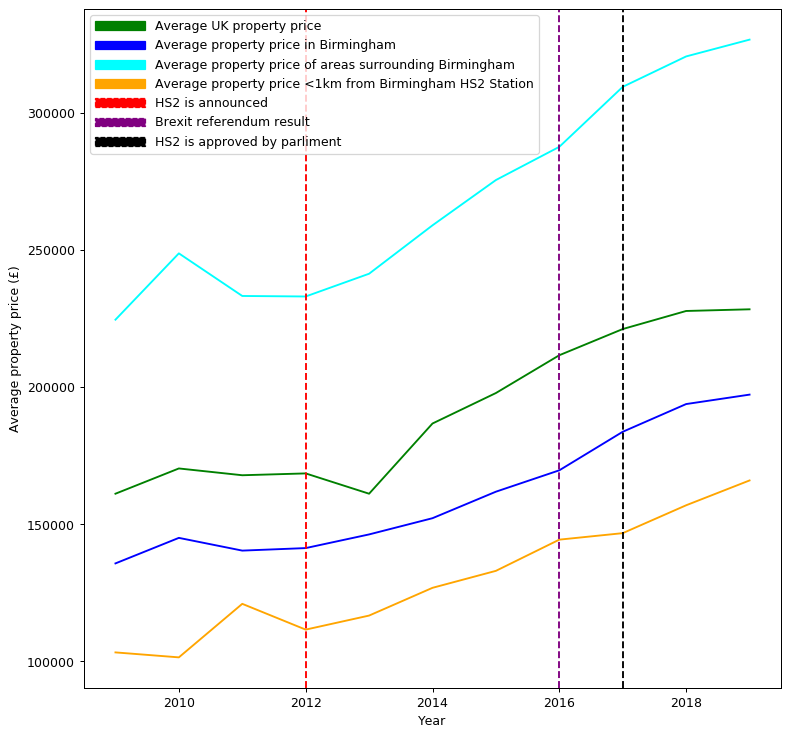

In [29]:
figure(num=None, figsize=(10, 10), dpi=90, facecolor='w', edgecolor='k')

blue_patch = mpatches.Patch(color='blue', label='Average property price in Birmingham')
orange_patch = mpatches.Patch(color='orange', label='Average property price <1km from Birmingham HS2 Station')
green_patch = mpatches.Patch(color='green', label='Average UK property price')
cyan_patch = mpatches.Patch(color='cyan', label='Average property price of areas surrounding Birmingham')
black_patch = mpatches.Patch(color='black', label='HS2 is approved by parliment', linestyle='--')
red_patch = mpatches.Patch(color='red', label='HS2 is announced', linestyle='--')
purple_patch = mpatches.Patch(color='purple', label='Brexit referendum result', linestyle='--')

leg = plt.legend(handles=[green_patch, blue_patch, cyan_patch, 
                          orange_patch, red_patch, purple_patch, black_patch],handlelength=4)

X = df_price_trend_all['SalePrice'].index

Y_all = df_price_trend_all['SalePrice'].values
Y_non_bham = df_price_trend_non_bham['SalePrice'].values
Y_close = df_price_trend_close['SalePrice'][1].values


plt.plot(X, Y_all, color='blue')
plt.plot(X, Y_non_bham, color='cyan')
plt.plot(X, Y_close, color='orange')
plt.plot(X, avg_uk_house_prices, color='green')

"""
pct_chg_Y_all = df_price_trend_all['Percent_change'].values
pct_chg_Y_non_bham = df_price_trend_non_bham['Percent_change'].values
pct_chg_Y_close = df_price_trend_close['Percent_change'].values
pct_chg_UK_avg = get_percent_changes(pd.DataFrame(avg_uk_house_prices))

for i in range(len(X)):
    plt.text(X[i], Y_all[i]+5000, pct_chg_Y_all[i], fontsize=8)
    plt.text(X[i], Y_non_bham[i]+5000, pct_chg_Y_non_bham[i], fontsize=8)
    plt.text(X[i], Y_close[i]+5000, pct_chg_Y_close[i], fontsize=8)
    plt.text(X[i], avg_uk_house_prices[i]+5000, pct_chg_UK_avg[i], fontsize=8)
"""

plt.axvline(x=2012, color='red', linestyle='--')
plt.axvline(x=2017, color='black', linestyle='--')
plt.axvline(x=2016, color='purple', linestyle='--')
    
plt.ylabel('Average property price (£)')
plt.xlabel('Year')

plt.show()

We can see a steady increase in property prices across all areas shown. It is worth looking at the years past 2017 in more detail, the UK and Birmingham prices increases start to slow but properties close to the HS2 station continue to increase at a rapid rate. See below for the numerical percentage increases for these areas.

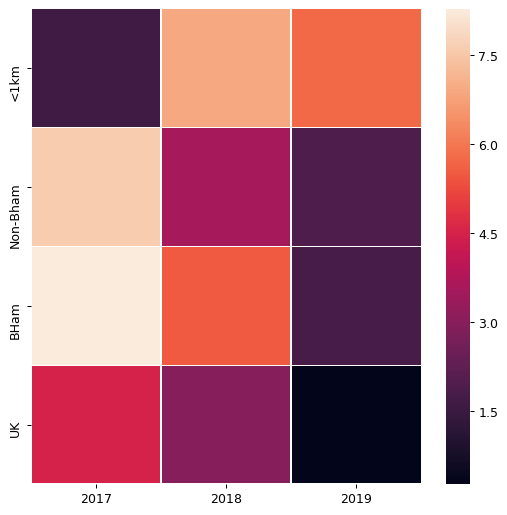

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

figure(num=None, figsize=(7,7), dpi=90, facecolor='w', edgecolor='k')

price_increase_data = np.array([df_price_trend_close['Percent_change'][1][[2017,2018,2019]].values, 
                                df_price_trend_non_bham['Percent_change'][[2017,2018,2019]].values,
                                df_price_trend_all['Percent_change'][[2017,2018,2019]].values,
                                [pct_chg_UK_avg[8], pct_chg_UK_avg[9], pct_chg_UK_avg[10]]])

price_increase_data = price_increase_data.astype(float)

ax = sns.heatmap(price_increase_data, linewidth=0.5)
ax.set_xticklabels(['2017','2018','2019'])
ax.set_yticklabels(['<1km','Non-Bham','BHam','UK'])
plt.show()

Overall it seems that Birmingham property prices as a whole are mimicing that of the rest of the UK, with the HS2 announcement not having a significant effect on the property prices. This may well change once the line is open.<br> <br> Properties within walking distance of the new HS2 station have seen price increases surpassing that of the UK average in recent years, we should see this continue as HS2 approaches completion assuming the project continues as expected.